# Algorithm Outline
 1) Initialize grid, physical parameters, and field arrays for ψ (streamfunction) and ω (vorticity).
 2) Time-marching loop (for each time step):
    a) Solve Poisson equation ∇²ψ = -ω for ψ via Successive Over-Relaxation (SOR).
    b) Compute vorticity at the solid boundaries directly from ψ (using ω = -∇²ψ) and lid velocity.
    c) Advect and diffuse interior ω using the vorticity transport equation (explicit FTCS).
 3) After convergence or final time, post-process and plot vorticity and streamfunction.

## Import libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D  # enables 3D plotting (not directly used here)
import numpy as np                      # numerical arrays and operations
import matplotlib.pyplot as plt         # plotting library

from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit import qasm2

from qiskit_aer import AerSimulator

from scipy.sparse import diags, eye, kron, identity, block_diag, csr_matrix
from scipy.sparse.linalg import spsolve
from scipy import linalg

# # Need to login to Classiq and authenticate your machine 
# authenticate();

from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
    ExecutionDetails,
)

from typing import List, Optional

## Set problem parameters

In [ ]:
# Python version 3.9 or newer

nx = 6       # number of grid points in x-direction
ny = 6       # number of grid points in y-direction
max_step = 5  # total number of time steps to march
visc = 0.1      # kinematic viscosity nu
u_wall = 1.0    # lid (top boundary) horizontal velocity

dt = 0.005      # time step size
dx = 1.0/(nx-1) # grid spacing (uniform) in both x and y

# === SOR (Successive Over-Relaxation) parameters for Poisson solver ===
max_iter = 100   # max iterations per time step for solving psi
beta = 1.5       # relaxation factor (>1 accelerates convergence)
max_err = 1e-4   # convergence tolerance for psi

# === HHL (QPE) parameters ===
precision = 6
dimension = (nx-2)*(ny-2) # Dimension of the A matrix

# === Field arrays initialization ===
psi   = np.zeros((nx, ny))  # streamfunction array 
# np.zeros((4,4)) =
# [[0. 0. 0. 0.]
#  [0. 0. 0. 0.]
#  [0. 0. 0. 0.]
#  [0. 0. 0. 0.]]
omega = np.zeros((nx, ny))  # vorticity array

omega0 = np.zeros_like(omega)  # temporary array for previous vorticity
# coordinate arrays for plotting
x = np.zeros((nx, ny))
y = np.zeros((nx, ny))

# Fill coordinate arrays assuming domain [0,1]x[0,1]
for i in range(nx):
    for j in range(ny):
        x[i,j] = dx * i  # x-coordinate at grid index i
        y[i,j] = dx * j  # y-coordinate at grid index j

## Quantum solver for Streamfunction, $\psi$

The streamfunction is 0 along the four boundaries. Hence, we only need to update streamfunction at the interior nodes. 

In python, the interior nodes have indices from $1$ to $n_x-2$. 

### Theory for $Ax=b$ Discretization

To calculate streamfunction, $\psi$, at the interior nodes, 

#### 1. Discretize the streamfunction equation

$$
\frac{\partial^{2}\psi}{\partial x^{2}}
\;+\;
\frac{\partial^{2}\psi}{\partial y^{2}}
\;=\;
-\omega
$$

to obtain

$$
\frac{\psi_{i+1,j} \;-\; 2\psi_{i,j} \;+\; \psi_{i-1,j}}{\Delta x^{2}}
\;+\;
\frac{\psi_{i,j+1} \;-\; 2\psi_{i,j} \;+\; \psi_{i,j-1}}{\Delta y^{2}}
\;=\;
-\omega_{i,j}
$$

assuming $\Delta x = \Delta y$, we have, for $i, j \in \mathbb{N}$

$$
4\psi_{i,j} - \psi_{i-1,j} - \psi_{i+1,j} - \psi_{i,j+1} - \psi_{i,j-1}
\;=\;
\omega_{i,j} \Delta x^{2} 
$$

We obtained a system of linear equations indexed by $(i, j)$.

We order these equations using **row-major order** (i.e., sweeping rows first):

$$
(i,j) \; = \; (1,1),\; (2,1),\; \dots,\; (n_x-2, 1),\; 
(1,2),\; (2,2),\; \dots,\; (n_x-2, 2),\; \dots,\; 
(1, n_y-2),\; (2, n_y-2),\; \dots,\; (n_x-2, n_y-2)
$$

#### 2. Convert to $Ax=b$.

Here, $x$ is the $\psi$ that we are trying to solve, $b$ is $\omega \Delta x^{2}$ on the right-hand side, and $A$ is the matrix of coefficients, made up of 4 and -1 and 0. 

We define the function `get_b()` to obtain the $b$ from the interior values of $\omega$, and the function `get_A()` to obtain the matrix $A$. 

There are two corner cases I want to talk about. For $(i,j)$ along the inside boundary, 
say, the bottom left corner at $(1,1)$, 
the equation becomes

$$
4\psi_{1,1} - \psi_{0,1} - \psi_{2,1} - \psi_{1,2} - \psi_{1,0}
\;=\;
\omega_{1,1} \Delta x^{2} 
$$

which, since $\psi_{0,1} = \psi_{1,0} = 0$, equals to

$$
4\psi_{1,1} - \psi_{2,1} - \psi_{1,2}
\;=\;
\omega_{1,1} \Delta x^{2} 
$$

More interestingly, at the bottom right corner at $(n_x-2,1)$, we have

$$
4\psi_{n_x-2,1} - \psi_{n_x-3,1} - \psi_{n_x-1,1} - \psi_{n_x-2,2} - \psi_{n_x-2,0}
\;=\;
\omega_{n_x-2,1} \Delta x^{2} 
$$
which implies, since $\psi_{n_x-1,1} = \psi_{n_x-2,0} = 0$,
$$
4\psi_{n_x-2,1} - \psi_{n_x-3,1} - \psi_{n_x-2,2}
\;=\;
\omega_{n_x-2,1} \Delta x^{2} 
$$

As a result, in the matrix $A$, for the diagonal entry corresponding to the index $(n_x-2,1)$, 
there is a "-1" immediately to the left, but not immediately to the right, and another "-1"
$n_x-1$ spaces to the right. 

#### 3. Solve $Ax=b$

Use classical or quantum solvers.

#### 4. Update $\psi$ using $x$. 

We define the function `recover_full_psi_from_flat()` to recover $\psi$. 


### Define helper functions

Define `get_A()`, `get_b()`, `recover_full_psi_from_flat()`, and `pad_to_power_of_two()` for quantum solvers.

In [3]:
# Prompt for generative AI to generate the get_A() function. 
"""
Given nx, ny and dx, define a function that construct the following symmetric matrix:
0. the symmetric matrix has size (nx-2)*(ny-2)
1. on the diagonal, we have 4
2. on the two sub-diagonal beside the main diagonal, has -1. 
3. for each row i, (i, i+nx-2) and (i, i-(nx-2)) also has -1. If index is outside of range, ignore. 
In other words, the diagonal that is shifted left and right from the main diagonal by (nx-2) also has -1.
"""

def get_A(nx: int, ny: int):
    """
    Build the (nx-2)*(ny-2) five-point Laplacian matrix
    with 4 on the diagonal, -1 on the ±1 sub/super-diagonals
    (excluding row-wrap connections), and -1 on the ±(nx-2) diagonals.
    Returns a CSR matrix of shape (N, N), where N=(nx-2)*(ny-2).
    
    We assume that the value of the discretized quantity (streamfunction psi in this case) at the 4 boundaries are 0. 
    Notice that in Python the indices range from psi[0,0] to psi[nx-1, ny-1], 
    where as in Engineering, the indices range from psi_(1,1) to psi_(nx,ny)
    """
    N_x = nx - 2
    N_y = ny - 2
    N   = N_x * N_y

    # main diagonal
    main =  4 * np.ones(N, dtype=float)

    # ---- horizontal neighbors (offset ±1), but zero out wrap-around
    # create a length-(N-1) array of -1’s
    off1 = -np.ones(N-1, dtype=float)
    # mask out entries where (i,i+1) would jump from end of one row to next
    idx   = np.arange(N-1)
    wrap  = (idx + 1) % N_x == 0
    off1[wrap] = 0.0

    # ---- vertical neighbors (offset ±N_x), no wrap issues
    offNx = -np.ones(N - N_x, dtype=float)

    # assemble
    diags_data = [ main,
                off1, off1,
                offNx, offNx ]
    offsets    = [  0,
                -1,   1,
                -N_x, N_x ]

    A = diags(diags_data, offsets, shape=(N, N), format='csr')
    return A

# # After building A as a CSR matrix you can use:
#    dense_A = A.toarray()        # convert to NumPy array

# # Or use qiskit for better visualization
# from qiskit.visualization import array_to_latex
# display(array_to_latex(A.toarray()))

def get_b(omega, dx):
    """
    Given vorticity omega os size nx x ny,
    extract omega from the interior and flatten to a vector.
    """
    b = omega[1:-1, 1:-1].flatten() * dx**2
    return b

def pad_to_power_of_two(
    A: csr_matrix | None   = None,
    b: np.ndarray  | None  = None
) -> csr_matrix | np.ndarray | tuple[csr_matrix, np.ndarray]:
    
    """
    Pad a sparse CSR matrix and/or vector to the next power-of-two dimension
    for qubit-based solvers.

    You may supply either:
        - A only  => returns padded A
        - b only  => returns padded b
        - A and b => returns (Apad, bpad)

    Parameters
    ----------
    A : scipy.sparse.csr_matrix, optional
        Original square matrix of shape (N, N).
    b : numpy.ndarray, optional
        Original right-hand side vector of length N.

    Returns
    -------
    Apad : scipy.sparse.csr_matrix
        Padded matrix of shape (2^n, 2^n) if A was provided.
    bpad : numpy.ndarray
        Padded RHS vector of length 2^n if b was provided.
    (Apad, bpad) : tuple
        If both A and b are given.
    """
    # Determine original size N
    if A is not None:
        N = A.shape[0]
    elif b is not None:
        b = np.asarray(b).flatten()
        N = b.shape[0]
    else:
        raise ValueError("Must provide at least one of A or b to pad.")

    # Compute next power of two ≥ N
    n_bits = (N - 1).bit_length()
    N2 = 1 << n_bits
    M = N2 - N

    # If already power-of-two, just return copy(s)
    if M == 0:
        if A is not None and b is not None:
            return A.copy(), b.copy()
        elif A is not None:
            return A.copy()
        else:
            return b.copy()

    # Build padding structures
    pad_id = identity(M, dtype=(A.dtype if A is not None else np.float64), format='csr')

    # Pad A if requested
    if A is not None:
        Apad = block_diag([A, pad_id], format='csr')
    # Pad b if requested
    if b is not None:
        bpad = np.empty(N2, dtype=b.dtype)
        bpad[:N] = b
        bpad[N:] = 0

    # Return according to inputs
    if A is not None and b is not None:
        return Apad, bpad
    elif A is not None:
        return Apad
    else:
        return bpad


def recover_full_psi_from_flat(psi_vec: np.ndarray, nx: int, ny: int, boundary: float = 0.0) -> np.ndarray:
    """
    Rebuild a full (nx x ny) array from a flattened interior vector psi_vec.

    Parameters
    ----------
    psi_vec : 1D np.ndarray, length = (nx-2)*(ny-2)
        Flattened (row-major) interior values.
    nx, ny : int
        Full grid dimensions.
    boundary : float, optional
        Dirichlet boundary value (default 0.0).

    Returns
    -------
    psi_full : 2D np.ndarray, shape (nx, ny)
        Full array with psi_full[1:-1,1:-1] filled from psi_vec
        and all boundaries set to `boundary`.
    """
    expected = (nx-2) * (ny-2)
    if psi_vec.size != expected:
        raise ValueError(f"Expected psi_vec of length {expected}, got {psi_vec.size}")
    
    # Reshape back to 2D interior
    interior = psi_vec.reshape((nx-2, ny-2))
    
    # Use psi_vec for the interior nodes
    psi_full = np.full((nx, ny), boundary, dtype=psi_vec.dtype)
    psi_full[1:-1, 1:-1] = interior
    
    return psi_full

We have obtained Ax=b of appropriate size from the previous step. 

The matrix, $A$, is Hermitian. However, its eigenvalues are not within 0 and 1. To apply HHL, we have to scale $A$.

In [4]:
# Check if a csr_matrix is hermitian.

def is_hermitian_sparse(A: csr_matrix, tol=1e-10) -> bool:
    """
    Check if a scipy.sparse.csr_matrix is Hermitian (A = A†).
    
    Parameters:
        A (csr_matrix): Input sparse matrix.
        tol (float): Numerical tolerance for element-wise comparison.
    
    Returns:
        bool: True if A is Hermitian within the given tolerance.
    """
    if A.shape[0] != A.shape[1]:
        return False  # must be square
    
    diff = (A - A.getH()).tocoo()  # getH() is conjugate transpose
    return np.all(np.abs(diff.data) < tol)

# Testing
print("Is the matrix Hermitian?")
is_hermitian_sparse(get_A(6,5))


Is the matrix Hermitian?


True

### Direct formula for eigenvalues

We estimate the eigenvalues of A so that we can prepare a matrix whose eigenvalue falls between 0 and 1 for QPE. 

For pentadiagonal Toeplitz matrices that we obtain from discretizing the streamfunction-vorticity equation, 
we have a direct formula for its eigenvalues. 

**1. Exact spectrum (separation–of–variables)**

For indices $(p,\; q)$ of $A$, and let $(N_x, N_y) = (n_x-2, n_y-2)$,
$$
p = 1, \dots, N_x,\;\; q = 1, \dots, N_y
$$

The eigenvectors factor into sines; the eigenvalues are
$$
\lambda_{p,q}
= 4
\;-\;2\cos\!\Bigl(\frac{\pi\,p}{N_x + 1}\Bigr)
\;-\;2\cos\!\Bigl(\frac{\pi\,q}{N_y + 1}\Bigr),
\quad
p = 1\ldots N_x,\;\;q = 1\ldots N_y.
$$

**2. Immediate upper and lower bounds**

**Smallest eigenvalue** (take $p=q=1$)  
$$
\lambda_{\min}
= 4
\;-\;2\cos\!\Bigl(\frac{\pi}{N_x + 1}\Bigr)
\;-\;2\cos\!\Bigl(\frac{\pi}{N_y + 1}\Bigr).
$$


**Largest eigenvalue** (take $p=N_x,\;q=N_y$)  
$$
\lambda_{\max}
= 4
\;+\;2\cos\!\Bigl(\frac{\pi}{N_x + 1}\Bigr)
\;+\;2\cos\!\Bigl(\frac{\pi}{N_y + 1}\Bigr)
\;<\;8.
$$

Hence a quick global bound for any grid is
$$
0
\;\le\;
\lambda
\;\le\;
8.
$$



In [5]:
# Claculating eigenvalues of A, using direct formula

def eigenvalues_laplacian(nx: int, ny: int) -> np.ndarray:
    """
    Compute the eigenvalues of the 5‑point Laplacian, pentadiagonal matrix on an
    (nx-2) by (ny-2) interior grid.

    Returns a 2D array of shape ((nx-2), (ny-2)) where
        Lambda[p-1, q-1] = 4 - 2*cos(pi*p/(nx-1)) - 2*cos(pi*q/(ny-1))
    for p=1..nx-2, q=1..ny-2.
    """
    Nx = nx - 2
    Ny = ny - 2

    # indices p=1..Nx, q=1..Ny
    p = np.arange(1, Nx+1)
    q = np.arange(1, Ny+1)

    # compute the two cosine terms
    cos_p = np.cos(np.pi * p / (Nx + 1))    # shape (Nx,)
    cos_q = np.cos(np.pi * q / (Ny + 1))    # shape (Ny,)

    # build the full (Nx x Ny) array via broadcasting
    Lambda = 4 \
           - 2 * cos_p[:, None] \
           - 2 * cos_q[None, :]

    return Lambda

def eigenrange_laplacian(nx, ny):
    """
    Compute the minimum and maximum eigenvalues of the discrete 2D Laplacian.

    The function calculates an estimate of the eigenvalue range for the
    Finite Difference discretization of the 2D Laplacian operator on a
    grid of size (nx, ny) with Dirichlet boundary conditions.

    Parameters
    ----------
    nx : int
        Number of grid points in the x-direction (including boundaries).
    ny : int
        Number of grid points in the y-direction (including boundaries).

    Returns
    -------
    tuple of float
        (lambda_min, lambda_max)
        Minimum and maximum eigenvalues of the discrete Laplacian.
    """
    Nx = nx - 2
    Ny = ny - 2

    min = (4 
    - 2 * np.cos(np.pi / (Nx + 1))
    - 2 * np.cos(np.pi / (Ny + 1)))

    max = (4 
    + 2 * np.cos(np.pi / (Nx + 1))
    + 2 * np.cos(np.pi / (Ny + 1)))

    return min, max

def scale_A(A:csr_matrix, lambda_min, lambda_max, precision):
    """
    Scale sparse matrix A so its eigenvalues fit into:
    [1/2^precision, 1]
    
    Formula:
    A_scaled = [(A - min*I)*(1-1/2**precision)/(max-min) 
    + 1/2**precision *I]
    
    Returns
    scipy.sparse.csr_matrix
    The scaled sparse matrix in csr format. 
    """
    dim = A.shape[0]
    I = identity(dim, format='csr')
    scale_factor = (1 - 1 / 2**precision) / (lambda_max - lambda_min)
    shift = 1 / 2**precision
    A_scaled = (A - lambda_min * I) * scale_factor + shift * I
    return A_scaled

def scale_b(b_vector: np.ndarray):
    """
    Normalize a vector to have unit L2 norm.
    
    Parameters
    ----------
    b_vector : np.ndarray
        Input vector to be normalized.
        
    Returns
    -------
    np.ndarray
        The normalized vector with L2 norm equal to 1.
    """
    
    b_norm = np.linalg.norm(b_vector)
    if b_norm == 0:
        return b_vector

    b_normalized = b_vector / b_norm
    return b_normalized

In [6]:
# Testing
# Calculating eignenvalues of A, using eigen solver.
# (nx,ny) = (6,5), A_dis is 12x12

w, v = np.linalg.eig(get_A(6,5).toarray())

m = 32  # Precision of a binary representation, e.g. 32 binary digits
sign = lambda num: "-" if num < 0 else ""  # Calculate sign of a number
binary = lambda fraction: str(
    np.binary_repr(int(np.abs(fraction) * 2 ** (m))).zfill(m)
).rstrip(
    "0"
)  # Binary representation of a fraction
print("Results for (6,5) grid, A is 12x12.")
print("Eigenvalues:")
for eig in sorted(w):
    print(f"{sign(eig)}0.{binary(eig.real)} =~ {eig.real}")

# Example usage:
nx1, ny1 = 6, 5
eigvals = eigenvalues_laplacian(nx1, ny1)
for eig in sorted(eigvals.ravel()):
    print(eig.real)

print("Are the two results the same?")
print(np.allclose(sorted(w), sorted(eigvals.ravel()), rtol=1e-20))


Results for (6,5) grid, A is 12x12.
Eigenvalues:
0.1111011110111110100111111101111 =~ 0.9677524488770097
0.11111011110111110100111111101111 =~ 1.967752448877013
0.100110000111001000100001100100011 =~ 2.381966011250108
0.1100110100001011011001001101010001 =~ 3.2038204263768
0.110110000111001000100001100100011 =~ 3.381966011250105
0.111100101111010010011011001010111 =~ 3.7961795736231996
0.10000110100001011011001001101010001 =~ 4.203820426376798
0.10010011110001101110111100110111001 =~ 4.618033988749892
0.1001100101111010010011011001010111 =~ 4.796179573623213
0.10110011110001101110111100110111001 =~ 5.618033988749896
0.11000001000010000010110000000100001 =~ 6.032247551122988
0.11100001000010000010110000000100001 =~ 7.032247551122998
0.96775244887701
1.96775244887701
2.381966011250105
3.2038204263768
3.381966011250105
3.7961795736232
4.2038204263768
4.618033988749895
4.7961795736232
5.618033988749895
6.03224755112299
7.03224755112299
Are the two results the same?
True


In [7]:
# Testing 
Nx = 4
Ny = 3
eigvals_min = (4 
    - 2 * np.cos(np.pi / (Nx + 1))
    - 2 * np.cos(np.pi / (Ny + 1)))
print(eigvals_min)

eigvals_max = (4 
    + 2 * np.cos(np.pi / (Nx + 1))
    + 2 * np.cos(np.pi / (Ny + 1)))
print(eigvals_max)

print(eigenrange_laplacian(6,5))
print(eigenrange_laplacian(4,4))


0.96775244887701
7.03224755112299
(0.96775244887701, 7.03224755112299)
(1.9999999999999998, 6.0)


### Prepare $A$ for Hamiltonian simulation (theory)

QPE requires that the eigenvalues of A to lie within 0 and 1. 

In quantum computing, the term `Hamiltonian simulation` refers to the following:

Given a Hermitian matrix, H, design an efficient quantum circuit that applies the unitary operations

$$
U(t) \; = \; e^{-iHt}
$$

to quantum states. 

For HHL and QPE, we want to simulate $U = e^{2 \pi iA}$

First, we scale $A$ so that its eigenvalues lie between 0 and 1. 
The scaled matrix is denoted $A'$. 

Let $m$ be the precision parameter of QPE and $\lambda$ be the eigenvalues of $A$.

$$
A'
= \frac{A - \lambda_{\min} I}{\lambda_{\max} - \lambda_{\min}} \bigl(1-\frac{1}{2^{m}}\bigr)
  + \frac{1}{2^{m}}\, I
$$

The eigenvalues of $A'$, $\lambda'$, lie within $[\frac{1}{2^{m}} , 1]$.

We use $A'$ for QPE, the output of which will prespresent eigenvalues of $A'$, $\lambda'$. 

For the controlled rotation (CR) block of HHL, we use the eigenvalues of $A$, not $A'$, as the controls.
This does not break HHL since the eigenvectors of $A$ and $A'$ are the same. 

The CR block performs the following operation on the `Indicator` qubit.

$$
|0 \rangle \; \mapsto \; \alpha|0\rangle + \frac{C}{\lambda}|1\rangle
$$

where $\alpha$ is some complex coefficient, and $C$ is a lowerbound of the eigenvalues of $A$. 
The factor $C \in \mathbb{R}$ ensures that the right-hand side is a valid quantum state. 
$C$ can be $\frac{1}{2^{m}}$.

The formula for recovering $\lambda$ from $\lambda'$ is given by

$$
\lambda = (\lambda' - \frac{1}{2^{m}}) (\lambda_{\max} - \lambda_{\min}) (\frac{2^{m}}{2^{m} -1}) + \lambda_{\min}
$$

In [ ]:
# # Formula for recovering lambda

# lambda_val = (
#     (phase - 1/2**precision)
#     * (lambda_max - lambda_min)
#     * (2**precision / (2**precision - 1))
#     + lambda_min
# )

In [8]:
# Testing
A = get_A(nx, ny)
b = get_b(omega, dx)
print(A.toarray())
print(b)

eigen_values = eigenvalues_laplacian(nx,ny)
print(eigen_values)

min, max = eigenrange_laplacian(nx,ny)
print(min, max)

[[ 4. -1. -1.  0.]
 [-1.  4.  0. -1.]
 [-1.  0.  4. -1.]
 [ 0. -1. -1.  4.]]
[0. 0. 0. 0.]
[[2. 4.]
 [4. 6.]]
1.9999999999999998 6.0


In [9]:
# Testing

# Prepare A_ so that eigenvalues of A_ is given by
# lambda_A_ = (lambda_A - min)/(max-min) + 1/2^precision

A_scaled = (A - min*np.identity(dimension))*(1-1/2**precision)/(max-min) + 1/2**precision*np.identity(dimension)
print(A_scaled)
print(np.linalg.eig(A_scaled)[0])

A2 = scale_A(A, *eigenrange_laplacian(nx, ny), precision)
print(A2.toarray())

[[ 0.50195312 -0.24902344 -0.24902344  0.        ]
 [-0.24902344  0.50195312  0.         -0.24902344]
 [-0.24902344  0.          0.50195312 -0.24902344]
 [ 0.         -0.24902344 -0.24902344  0.50195312]]
[0.00390625 0.50195312 1.         0.50195312]
[[ 0.50195312 -0.24902344 -0.24902344  0.        ]
 [-0.24902344  0.50195312  0.         -0.24902344]
 [-0.24902344  0.          0.50195312 -0.24902344]
 [ 0.         -0.24902344 -0.24902344  0.50195312]]


As we can see, the eigencalues lie between 1/32 (0.0132) and 1, where precision is 5. 

In [34]:
# Decompose A_norm into Pauli strings

# hamiltonian = matrix_to_hamiltonian(A)
# n = len(hamiltonian[0].pauli)

# print("Pauli strings list: \n")
# for pterm in hamiltonian:
#     print(pterm.pauli, ": ", np.round(pterm.coefficient, 7))

# print("\nNumber of qubits for matrix representation =", n)

In [10]:
print(scale_A(A, *eigenrange_laplacian(nx,ny), precision).toarray())

[[ 0.50195312 -0.24902344 -0.24902344  0.        ]
 [-0.24902344  0.50195312  0.         -0.24902344]
 [-0.24902344  0.          0.50195312 -0.24902344]
 [ 0.         -0.24902344 -0.24902344  0.50195312]]


### Classiq HHL algorithm

#### Define HHL function

In [12]:
# Encode b as amplitudes
@qfunc
def load_b(amplitudes: CArray[CReal], state: Output[QArray]) -> None:
    prepare_amplitudes(amplitudes, 0.0, state)

# Function for the main quantum program
@qfunc
def hhl(
    rhs_vector: CArray[CReal],
    precision: CInt,
    hamiltonian_evolution_with_power: QCallable[CInt, QArray],
    state: Output[QArray],
    phase: Output[QNum],
    indicator: Output[QBit],
):
    # Allocate "precision" number of qubits. All of which are fractions: 0.123456. For comparison consider 12.3456
    # The quantum register that holds this info is called "phase".
    allocate(num_qubits=precision, is_signed=UNSIGNED, fraction_digits=precision, out=phase) 

    # Prepare "b", assigned to a quantum register called "state". 
    load_b(amplitudes=rhs_vector, state=state)

    # Allocate a single qubit to the quantum register called "indicator". 
    # We will perform controlled rotations onto this "indicator". 
    allocate(indicator)
    
    # Perform quantum phase estimation and eigenvalue inversion
    within_apply(
        # Within block: on the outside, i.e., QPE and QPE^-1
        lambda: qpe_flexible(
            # A function that performs U operation k (or 2^k) times on the quantum register, "state", which encodes b. 
            unitary_with_power =
                # hamiltonian_evolution_with_power(k, qreg) is the function that generates U from A, 
                # and can repeat itself k (or 2^k) times. 
                lambda k: hamiltonian_evolution_with_power(k, state),
            # The outputs (eigenvalues info) are stored in the "phase" quantum register
            phase=phase,
        ),
        # Apply block: CR block (on the inside)
        # Generates C/lambda |1>, where C = lambda_min. Note that C must be a lower bound for the smallest eigenvalue.
        # However, this also explains why synthesis takes so long. 
        # We are supposed to perform the controlled rotations with eigenvalues as controls, and the indicator is the target.
        # But here, it computes classical arithmetics to obtain C/lambda given variable lambda, 
        # then assigns C/lambda to the indicator qubit. 
        lambda: assign_amplitude(
            # Here, we assign the correct amplitide based on the original eigenvalues of A, not of A'. 
            # In other words, A' is rescaled back to A at this step. 
            min / (
                (phase - 1/2**precision)
                * (max - min)
                * (2**precision / (2**precision - 1))
                + min
            ),
            # C/lambda is amplitude assigned to the indicator qubit
            indicator
        ),
    )


# # Convert to qiskit circuit
# def hhl_circ(main):
#     qmod_hhl = create_model(main)
#     qprog = synthesize(qmod_hhl)
#     qcode = qprog.to_program()
#     qc = qasm2.loads(qcode.code)
#     return qc

# def eval_qc(qc, backend):
#     qc_transpiled = transpile(circuits=qc, 
#                             backend=backend, 
#                             optimization_level=2, 
#                             layout_method="dense")
#     qc_transpiled.save_statevector()
    
#     job = simulator.run(qc_transpiled)
#     result = job.result()
    
#     sv = result.get_statevector(qc_transpiled)
    
#     return sv

# # Postprocess


#### Classiq Execution and Synthesis preferences

In [25]:
# Prepare quantum model for simulation with optional preferences.
def hhl_model(main, backend_preferences, synthesis_preferences=None, num_shots=1):
    qmod_hhl = create_model(
        main,
        execution_preferences=ExecutionPreferences(
            num_shots=num_shots, backend_preferences=backend_preferences
        ),
        preferences=synthesis_preferences,
    )
    return qmod_hhl

#### Hamiltonian Simulation

For QPE, we want to define or approximate a unitary matrix, $U$, corresponding to $A'$ so that

$$
U(t) \; = \; e^{iA't}
$$

This is not the convention. 

1. Direct simulation
2. Other methods

#### Post-processing

`phase_position()` replaces `read_positions()` in the tutorial, as it has redundant outputs which are misleading. 

> Important: Although the `phase` register is given qubit indices in the order (q0, q1, q2, q3, q4), the corresponding `phase_pos` are ordered in reverse as (7, 6, 5, 4, 3). 

This is because `phase_pos` are positions of written bitstrings, ordered from Most Significant Bit (MSB) to Least Significant Bit (LSB) from left to right by natural language conventions. For written bitstrings, the indices are ordered as (0,1,2,3,4,...) where MSB is given the smallest index, 0. However, Classiq follows little-Endian convention for circuit diagrams (like qiskit), where MSB appears at the bottom of circuit diagrams and is given the largest qubit index, following Classiq's syntax. This syntax also applies when coding in Classiq Python library and Qmod programming language. 

In [14]:
def phase_position(circuit_hhl, res_hhl):
    """
    Given a qubit layout ordered as ppppIrrr (physical indices),
    return the bitstring positions of the phase qubits in the
    measured string ordered rrrIpppp.
    
    Returns
    -------
    List[int]
        Positions in the bitstring for the phase register (ordered for direct slicing).
    """
    total_q = circuit_hhl.data.width
    qubit_pos = res_hhl.physical_qubits_map["phase"]
    # Flip order for endianness so bitstring indexing works correctly
    phase_pos = [total_q - 1 - k for k in qubit_pos]
    return phase_pos

# Old read_positions() function is misleading. 
# Given qubits_map {'res': (6, 7), 'phase': (0, 1, 2, 3, 4), 'indicator': (5,)}
# read_positions() gives sol=[6, 7], phase=[7, 6, 5, 4, 3], and target=[5]. 

def quantum_solution(
    circuit_hhl: QuantumProgram, 
    res_hhl: ExecutionDetails, 
    precision: int, 
    C: float | None = None
    ):
    
    """
    Extract useful information from Classiq simulation output.
    Collect the amplitudes of a selection of basis states.
    
    Parameters
    ----------
    circuit_hhl: Classiq QuantumProgram, qprog
        Only used for figuring out the position of phase qubits in the ExecutionDetails
    
    res_hhl: Classiq ExecutionDetails
    
    precision: int
        precision of eigenvalue (phase) estimation for QPE, in # of phase qubits. 
    
    C: float
        C is a lowerbound of the eigenvalues of the prescaled A matrix, 
        or a lowerbound of whichever set of eigenvalues used in C/lambda in the CR block.
    
    Returns
    -------
    qsol: List
        List of amplitudes
    
    """
    # Added safety in case old read_position() function is used. 
    phase_pos = phase_position(circuit_hhl, res_hhl)
    
    # The number of qubits for b, or "res". 
    n = len(res_hhl.physical_qubits_map["res"])
    
    if C == None:
        C = 1/(2**precision) # This default value is for the demo written by Classiq developers
        # Small enough to be safe, but is inefficient.
    
    qsol = [ 
        parsed_state.amplitude / C # Extract amplitudes corresponding to 1/lambda
        
        for solution in range(2**n)
        for parsed_state in res_hhl.parsed_state_vector
        # Scan over all unique measurement outputs, |rrrIpppp>, that satisfies the following
        
        if parsed_state["indicator"] == 1.0 # Indicator is |1>
        and parsed_state["res"] == solution # combine outputs with the same "res" pattern |rrr>
        and [parsed_state.bitstring[k] for k in phase_pos] == ["0"] * precision # all phase qubits are 0.
        # If phase qubits are not 0 after QPE inverse, this means QPE did not pick the best phase approximation
        # Note that QPE does not guarantee the best approximation
    ]
    return qsol

import matplotlib.pyplot as plt

# Method 2 Post-processing
# To combat noise, minimize imaginary part across all entries, instead of just using the first entry.

def quantum_solution_preprocessed_2(
    A_prescale:  np.ndarray, 
    b:           np.ndarray,
    circuit_hhl: QuantumProgram, 
    res_hhl:     ExecutionDetails, 
    precision:   int, 
    C:           float | None = None, 
    disp:        bool = True,
    ):
    
    """
    Solve A_prescale x = b both classically and via the HHL-based quantum routine, then
    preprocess the raw quantum output by choosing the global phase that
    minimizes the imaginary norm across all components.

    This uses the fact that for any complex vector q, the φ which minimizes
        || Im(e^{-iφ} q) ||₂
    is given by
        φ_opt = ½ · arg( Σ_j q_j² ).

    After phase‐alignment, we take the real part and fix any overall ± sign
    to match the classical solution.
    
    Parameters
    ----------
    A : (n, n) ndarray
        Real, invertible matrix.
    b : (n,) ndarray
        Real right‐hand side vector.
    circuit_hhl : Classiq QuantumProgram
        Encodes the HHL quantum subroutine.
    res_hhl : Classsiq ExecutionDetails
        Raw output from executing the HHL circuit on Classiq server.
    precision : int
        Number of qubits in the phase register.
    C : float or None, optional, but required for streamfunction vorticity
        Constant scaling factor for CR block of HHL, default to 1/(2**precision)
    disp : bool, optional
        If True, print both classical and (normalized) quantum solutions.
    
    Returns
    -------
    sol_classical : (n,) ndarray
        Exact solution of A x = b.
    qsol_corrected : (n,) ndarray
        Real vector obtained from the quantum output after optimal global‐phase
        alignment and sign correction, ready for direct comparison to sol_classical.
    """
    # 1) Classical solution
    sol_classical = np.linalg.solve(A_prescale, b)
    if disp:
        print("Classical Solution:         ", sol_classical)
    
    # 2) Raw quantum solution (complex amplitudes)
    qsol = quantum_solution(circuit_hhl, res_hhl, precision, C)
    if disp:
        normed = np.abs(qsol) / np.linalg.norm(qsol)
        print("Quantum Solution (prob amp):", normed)
    
    # 2b) Convert qsol from list to array
    qsol = np.array(qsol, dtype=complex)
    
    # 3) Optimal global‐phase φ that minimizes imaginary parts across all components
    # φ_opt = 0.5 * arg( Σ_j qsol[j]^2 )
    # np.angle() produces the phase of a complex number 
    phi_opt = 0.5 * np.angle(np.sum(qsol**2))
    
    # 4) Phase‐rotate and take real part
    qsol_rot   = qsol * np.exp(-1j * phi_opt)
    qsol_real  = np.real(qsol_rot)
    
    # 5) Fix any overall ± sign so first entry matches classical sign
    # sign_fix      = np.sign(sol_classical[0]) * np.sign(qsol_real[0])
    # qsol_corrected = sign_fix * qsol_real
    
    # 5) Robust overall sign correction
    # Prefer aligning by the inner product; fallback to largest-magnitude component if overlap is too small.
    overlap = np.vdot(sol_classical, qsol_real)  # since both are real-valued after rotation, this should be real
    overlap_real = overlap.real if np.iscomplexobj(overlap) else overlap
    norm_prod = np.linalg.norm(sol_classical) * np.linalg.norm(qsol_real)
    # threshold relative to typical scale (avoid division by zero)
    eps = 1e-8 * norm_prod
    if abs(overlap_real) > eps:
        # If the two solutions are nearly perpendicular with cosine less than 1e-8
        sign_fix = np.sign(overlap_real)  # +1 if aligned, -1 if flipped
    else:
        # fallback: pick index of largest magnitude in classical solution
        idx = int(np.argmax(np.abs(sol_classical)))
        sign_fix = np.sign(sol_classical[idx]) * np.sign(qsol_real[idx])
    qsol_corrected = sign_fix * qsol_real
    return sol_classical, qsol_corrected


def show_solutions(A_prescale, b, circuit_hhl, res_hhl, precision, C = None, check=True, disp=True):
    # Classical solution and preprocessed quantum solution
    # Method 2 is used
    sol_classical, qsol_corrected = quantum_solution_preprocessed_2(
        A_prescale, b, circuit_hhl, res_hhl, precision, C=C, disp=disp
    )
    
    # Verify is there is no functional error, 
    # which might come from changing endianness in Model or Execution
    if (
        np.linalg.norm(sol_classical - qsol_corrected) / np.linalg.norm(sol_classical)
        > 0.1
        and check
    ):
        raise Exception(
            "The HHL solution is too far from the classical one, please verify your algorithm"
        )
    
    if disp:
        print("Corrected Quantum Solution: ", qsol_corrected)
    
    # Fidelity
    state_classical = sol_classical / np.linalg.norm(sol_classical)
    state_corrected = qsol_corrected / np.linalg.norm(qsol_corrected)
    fidelity = np.abs(np.dot(state_classical, state_corrected)) ** 2
    print()
    print("Fidelity:                   ", f"{np.round(fidelity * 100,2)} %")
    
    if disp:
        plt.plot(sol_classical, "bo", label="Classical")
        plt.plot(qsol_corrected, "ro", label="HHL")
        plt.legend()
        plt.xlabel("$i$")
        plt.ylabel("$x_i$")
        plt.show()

### HHL solver for Streamfunction

#### Inputs for the HHL solver

1. `omega` for the current time-step
2. `nx` and `ny` and `dx` (fixed for all time-steps)
3. `precision` for QPE
4. preferences


In [23]:
backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)

synthesis_preferences = Preferences(
        optimization_level= 2, timeout_seconds=10000, optimization_timeout_seconds=8000
        )


#### Define hhl solver

In [17]:
# Exact Hamiltonian version
def solve_classiq_hhl_exact(
    nx, ny, dx, precision, omega, 
    backend_preferences, synthesis_preferences,
    ):
    
    #### Set up parameters
    # ===============================
    A_prescale = get_A(nx, ny)
    b_prescale = get_b(omega, dx)
    b_norm = np.linalg.norm(b_prescale)
    
    # Normalized b vector
    b = scale_b(b_prescale)
    
    # min and max of eigenvalues
    min, max = eigenrange_laplacian(nx, ny)
    
    # Scale A so that the eigenvalues are between 0 and 1. 
    A = scale_A(A_prescale, min, max, precision)
    
    A = A.toarray()
    A_prescale = A_prescale.toarray()
    
    # Parameters for the initial state preparation
    amplitudes = b.tolist()
    
    #### Define @qfunc main()
    # ==================================
    # Using exacting Hamiltonian
    @qfunc
    def unitary_with_power_logic(
        pw: CInt, matrix: CArray[CArray[CReal]], target: QArray[QBit]
    ) -> None:
        power(pw, lambda: unitary(elements=matrix, target=target))
    
    @qfunc
    def main(
        res: Output[QNum],
        phase: Output[QNum],
        indicator: Output[QBit],
    ) -> None:
        # Calling hhl()
        hhl(
            rhs_vector=amplitudes,
            precision=precision,
            hamiltonian_evolution_with_power=lambda pw, target: unitary_with_power_logic(
                # pw is the power k, target is "state" register
                matrix=linalg.expm(2 * np.pi * 1j * A).tolist(), pw=pw, target=target
            ),
            state=res,
            phase=phase,
            indicator=indicator,
        )
    
    #### Model creation and processing
    # ==================================
    # Construct HHL model for streamfunction, psi
    qmod_psi_exact = hhl_model(main, backend_preferences, synthesis_preferences)
    
    # Synthesize
    qprog_psi_exact = synthesize(qmod_psi_exact)
    
    # Extract the qunatum solution
    res_psi_exact = execute(qprog_psi_exact).result_value()
    _, qsol_prescale = quantum_solution_preprocessed_2(
        A_prescale, b, qprog_psi_exact, res_psi_exact, precision, C=min, disp=False)
    qsol = qsol_prescale * b_norm
    psi = recover_full_psi_from_flat(qsol, nx, ny)
    return psi

## SOR solver for Streamfunction, psi

In [18]:
def solve_streamfunction_sor(psi_init, omega, dx, beta, max_iter, max_err):
    """
    Solve ∇²ψ = –ω on the interior of a (nx×ny) grid by SOR in place.
    
    Parameters
    ----------
    psi : 2D ndarray, shape (nx,ny)
        Initial guess for the streamfunction.
    omega : 2D ndarray, shape (nx,ny)
        Current vorticity field (source term).
    dx : float
        Grid spacing (assumed equal in x and y).
    beta : float
        Relaxation factor (1<beta<2 for over–relaxation).
    max_iter : int
        Maximum number of SOR sweeps.
    tol : float
        Convergence tolerance on the L1 change in ψ.
    
    Returns
    -------
    psi : 2D ndarray
        Updated streamfunction (in place).
    iters : int
        Number of iterations actually performed.
    """
    nx, ny = psi_init.shape
    psi = psi_init.copy()
    for it in range(1, max_iter + 1):
        psi_old = psi.copy()
        # Update interior points using SOR
        for i in range(1, nx-1): # range(1,3) = [1, 2]
            for j in range(1, ny-1):
                # 5-point Laplacian + source term (vorticity)
                psi[i, j] = (
                    (1 - beta)*psi[i, j]
                    + (beta * 0.25) * (
                        psi[i+1, j] + psi[i-1, j]
                        + psi[i, j+1] + psi[i, j-1]
                        + dx*dx * omega[i, j]
                    )
                )
        # check convergence (L1 norm)
        err = np.sum(np.abs(psi - psi_old))
        if err < max_err:
            return psi, it, err
    return psi, max_iter, err

## Vorticity transport

First, define `vorticity_transport()` function to update the vorticity (omega) to the next timestep. The inital vorticity is all zero.

In [19]:
def vorticity_transport(psi, omega):
    """The goal is to be able to perform a single timestep for testing and verification.
    To print or save the omega at each timestep. 
    
    Given psi and omega from the current timestep, calculate omega for the next timestep.
    
    Return updated omega
    """
    
    omega_next = omega.copy() # Initialize next timestep vorticity
    omega0 = omega.copy()  # store old vorticity
    
        # ----- 1) Update omega for the next timestep -----
    #   a) Apply and calculate boundary vorticity at walls
    # Vorticity ω is computed at the walls directly from ψ (streamfunction) via ω = -∇²ψ,
    # with an extra term on the moving lid: ω = -2ψ/dx² - 2u_wall/dx for y = 1
    # This sets ω on the bottom, top, left and right boundaries.
    
    # bottom wall (y=0): u=0 => psi=0 => vorticity = -2*psi[...]/dx^2
    omega_next[1:nx-1, 0] = -2.0 * psi[1:nx-1, 1] / (dx*dx)
    # top lid (y=1): u=u_wall, psi=0 => includes lid velocity contribution
    omega_next[1:nx-1, ny-1] = -2.0 * psi[1:nx-1, ny-2] / (dx*dx) - 2.0 * u_wall / dx
    # left wall (x=0): psi=0
    omega_next[0, 1:ny-1] = -2.0 * psi[1, 1:ny-1] / (dx*dx)
    # right wall (x=1): psi=0
    omega_next[nx-1, 1:ny-1] = -2.0 * psi[nx-2, 1:ny-1] / (dx*dx)
    
    #   b) Compute interior vorticity transport: advect + diffuse
    # Interior vorticity ω at each grid point is updated using the vorticity transport equation:
    # ∂ω/∂t + u ∂ω/∂x + v ∂ω/∂y = ν ∇²ω, discretized explicitly (FTCS).
    # Here ω0 holds the previous time step's vorticity.
    for i in range(1, nx-1): # inner nodes
        for j in range(1, ny-1): # inner nodes
            # compute convective term: u * d(omega)/dx + v * d(omega)/dy
            adv =  -0.25 * (
                    (psi[i,j+1] - psi[i,j-1]) * (omega0[i+1,j] - omega0[i-1,j])
                  - (psi[i+1,j] - psi[i-1,j]) * (omega0[i,j+1] - omega0[i,j-1])
                ) / (dx*dx)
            # diffusion term: nu * Laplacian(omega)
            diff = visc * (
                    omega0[i+1,j] + omega0[i-1,j]
                    + omega0[i,j+1] + omega0[i,j-1]
                  - 4.0 * omega0[i,j]
                ) / (dx*dx)
            # update vorticity explicitly
            omega_next[i,j] = omega0[i,j] + dt * (adv + diff)
    return omega_next


## Tests for poisson discretization

First, perform two timestep iterations to obtain vorticity, omega_2, at the timestep 2. 

Next, solve for streamfunction at timestep 2, psi_2, using both the SOR and classical linear solver (by solving Ax=b). 

Compare the results. We want to verify the correctness of our discretized poisson system of linear equations, A and b, which we obtained using functions `get_b()` and `get_A()`.

Since SOR algorithm is only an approximation with error within `max_err` and Classical linear solver outputs the exact solution. For more accurate comparison, set `max_err` sufficiently low. 

In [46]:
# Obtain omega_2

omega_1 = vorticity_transport(psi=psi, omega=omega)
psi_1, *_ = solve_streamfunction_sor(psi, omega_1, dx, beta, max_iter, max_err=1e-4)
print("omega_1 and psi_1:")
print(omega_1, psi_1, sep="\n")

print("Second evolution:")
omega_2 = vorticity_transport(psi=psi_1, omega=omega_1)
print(f"Omega_2: \n {omega_2}")

psi_2, *_ = solve_streamfunction_sor(psi_1, omega_2, dx, beta, max_iter, max_err=1e-8)
print(f"psi_2 from SOR: \n {psi_2}")

omega_1 and psi_1:
[[ 0. -0. -0.  0.]
 [-0.  0.  0. -6.]
 [-0.  0.  0. -6.]
 [ 0. -0. -0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Second evolution:
Omega_2: 
 [[ 0.    -0.    -0.     0.   ]
 [-0.     0.    -0.027 -6.   ]
 [-0.     0.    -0.027 -6.   ]
 [ 0.    -0.    -0.     0.   ]]
psi_2 from SOR: 
 [[ 0.        0.        0.        0.      ]
 [ 0.       -0.000375 -0.001125  0.      ]
 [ 0.       -0.000375 -0.001125  0.      ]
 [ 0.        0.        0.        0.      ]]


In [47]:
# Set up for classical linear solver
A_dis = get_A(nx, ny)
print("A:")
print(A_dis.toarray())

b_dis = get_b(omega_2, dx)
print("b:")
print(b_dis)

x_dis = spsolve(A_dis, b_dis)

psi_full = recover_full_psi_from_flat(x_dis, nx, ny)
print("psi_2 from classical linear solver: ")
print(psi_full)

A:
[[ 4. -1. -1.  0.]
 [-1.  4.  0. -1.]
 [-1.  0.  4. -1.]
 [ 0. -1. -1.  4.]]
b:
[ 0.    -0.003  0.    -0.003]
psi_2 from classical linear solver: 
[[ 0.        0.        0.        0.      ]
 [ 0.       -0.000375 -0.001125  0.      ]
 [ 0.       -0.000375 -0.001125  0.      ]
 [ 0.        0.        0.        0.      ]]


In [48]:
# Compare classical result with SOR result:

print("Is SOR solution 1e-4 close to classical linear solver solution?")
np.allclose(psi_2, psi_full, rtol=1e-4, atol=1e-4)

Is SOR solution 1e-4 close to classical linear solver solution?


True

In [49]:
example_A = get_A(10,10).toarray()

np.savetxt("clipboard.txt", example_A, delimiter='\t', fmt="%.6f")

In [ ]:
# Set up for quantun linear solver
x_qdis = solve_classiq_hhl_exact(
    nx, ny,dx, precision,omega_2,
    backend_preferences, synthesis_preferences)

In [58]:
print(f"Classical Solver: \n {psi_full}")
print(f"Quantum Solver: \n {x_qdis}")

Classical Solver: 
 [[ 0.        0.        0.        0.      ]
 [ 0.       -0.000375 -0.001125  0.      ]
 [ 0.       -0.000375 -0.001125  0.      ]
 [ 0.        0.        0.        0.      ]]
Quantum Solver: 
 [[ 0.          0.          0.          0.        ]
 [ 0.         -0.00037476 -0.00112524  0.        ]
 [ 0.         -0.00037476 -0.00112524  0.        ]
 [ 0.          0.          0.          0.        ]]


## Time-marching Loop

#### SOR loop

In [69]:
# Time-marching loop
t_current = 0.0
for tstep in range(max_step):
    # ----- 1) Update omega for the next timestep, using vorticity transport with FTCS discretization -----
    omega = vorticity_transport(psi, omega)
    
    # ----- 2) Solve Poisson equation for streamfunction psi -----
    # Given omega_new for tstep+1, returns updated streamfunction, psi[:,:] for tstep+1. 
    # SOR
    psi, sor_iters, err = solve_streamfunction_sor(
        psi, omega, dx, beta, max_iter, max_err)
    # can use psi, *_ = solve_streamfunction_sor(...) to collect just the psi. 
    
    t_current += dt  # advance physical time

#### Quantum HHL loop

In [27]:
# Time-marching loop
t_current = 0.0
for tstep in range(max_step):
    # ----- 1) Update omega for the next timestep, using vorticity transport with FTCS discretization -----
    omega = vorticity_transport(psi, omega)
    
    # ----- 2) Solve Poisson equation for streamfunction psi -----
    # Given omega_new for tstep+1, returns updated streamfunction, psi[:,:] for tstep+1. 
    psi = solve_classiq_hhl_exact(
    nx, ny,dx, precision,omega,
    backend_preferences, synthesis_preferences)
    
    t_current += dt  # advance physical time

## Post-processing: plot results

In [ ]:
def plot_results(psi, omega):
    try:
        print(f"Converged psi error: {err:.2e}")
    except NameError:
        pass
    # Plot vorticity and streamfunction side-by-side
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.contour(x, y, omega, 40)
    plt.title(r"Vorticity $\omega$")
    plt.axis('square')

    plt.subplot(1,2,2)
    plt.contour(x, y, psi, 20)
    plt.title(r"Streamfunction $\psi$")
    plt.axis('square')

    plt.tight_layout()
    plt.show()

plot_results(psi, omega)

Converged psi error: 4.65e-05


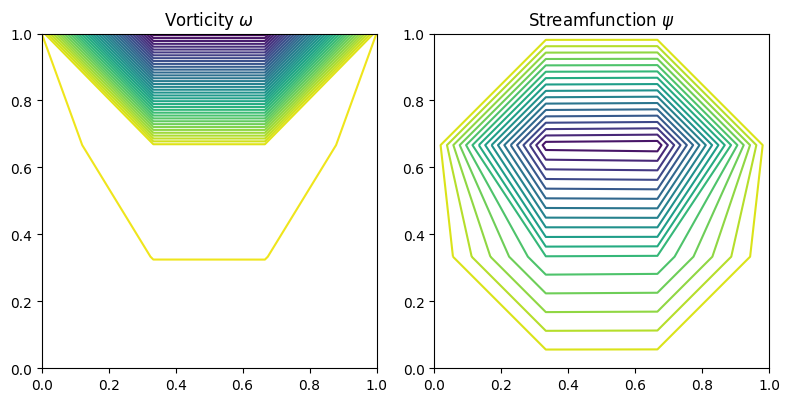